In [1]:
#Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
from datetime import datetime
import datetime
import time
import timestring
import math
import scipy
matplotlib.rcParams['figure.figsize'] = (14, 8)

In [2]:
year = '2017'

In [3]:
#read in the csv file for desired year
df = pd.read_csv(f'./Data/{year}.csv')

In [4]:
#remove rows with NaN values ~1.5% of data 
df = df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

In [5]:
#Optimize performance
#convert the object columns to categorical
cat_label = lambda x: x.astype('category')
objects = ['FL_DATE','OP_CARRIER', 'ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR', 'DEST','DEST_CITY_NAME',
           'DEST_STATE_ABR']
df[objects] = df[objects].apply(cat_label, axis=0)

#reduce the size of integer columns
convert_int = lambda x: pd.to_numeric(x, downcast='unsigned')
integers = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
df[integers] = df[integers].apply(convert_int, axis=0)

#reduce the size of float columns
convert_float = lambda x: pd.to_numeric(x, downcast='float')
floats = ['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 
          'TAXI_IN','ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 
          'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df[floats] = df[floats].apply(convert_float, axis=0)

#### Split the data into appropriate delay intervals

In [6]:
#all arrival delays
delays = df[df.ARR_DELAY > 0]
#arrival delays more than 15 minutes
delays_15 = df[df.ARR_DELAY > 15]
#arrival delays longer than 4 hrs
delays_4hr = df[df.ARR_DELAY / 60 >=4]
#arrival delays more than 15mins and less than 4 hrs
delays_15_4 = df[(df.ARR_DELAY / 60 < 4) & (df.ARR_DELAY > 15)]

In [178]:
df.YEAR.count()

5579410

In [179]:
delays_15.YEAR.count()

992420

# EDA 

## Distribution of Arrival Delays for all flights (includes negative values for early flights)

(-100, 200)

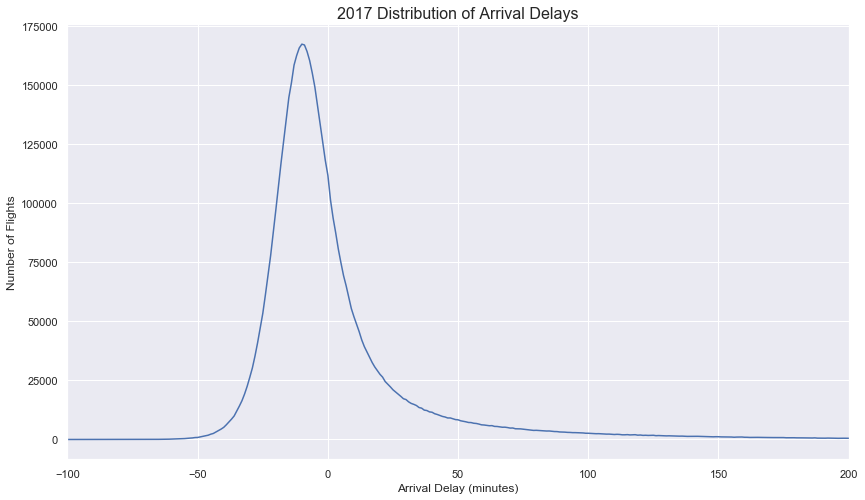

In [174]:
df.groupby('ARR_DELAY').size().plot()
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Number of Flights')
plt.title('2017 Distribution of Arrival Delays', fontsize=16)
plt.xlim(-100,200)

## Distribution of long flights vs short flights

In [9]:
short_route = df[df.AIR_TIME < 180]
long_route = df[df.AIR_TIME >= 180]

Short flight average delay: 4.436861991882324
Long flight average delay: 3.7993462085723877


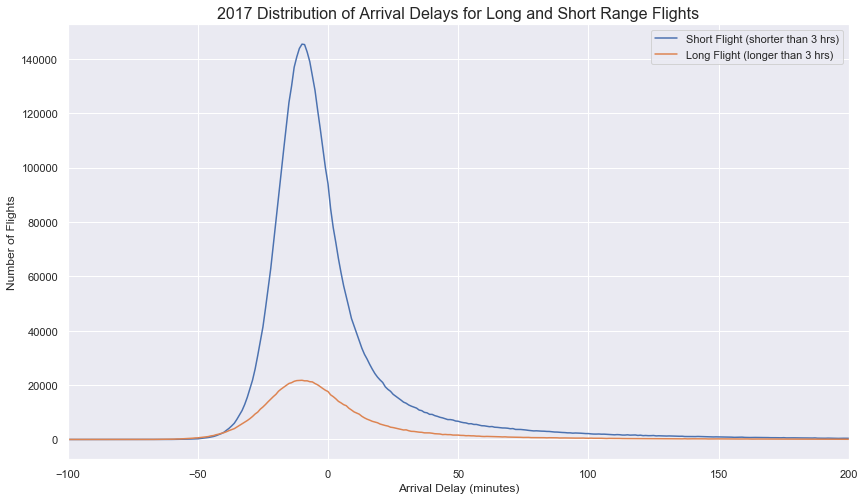

In [175]:
short_route.groupby('ARR_DELAY').size().plot()
long_route.groupby('ARR_DELAY').size().plot()
plt.xlim(-100,200)
plt.ylabel('Number of Flights')
plt.title('2017 Distribution of Arrival Delays for Long and Short Range Flights', fontsize=16)
plt.xlabel('Arrival Delay (minutes)')
plt.legend(['Short Flight (shorter than 3 hrs)', 'Long Flight (longer than 3 hrs)'])

print(f'Short flight average delay: {short_route.ARR_DELAY.mean()}')
print(f'Long flight average delay: {long_route.ARR_DELAY.mean()}')

### The distribution of arrival delays is heavily skewed, with majority of the arrivals being on-time or early. 
#### One possible way to model the data is to classify if a flight will be delayed or not with a probability. Then we can use linear regreassion or random forrests to determine the length of delay

## Distribution of delayed flights by airline:

In [11]:
print(f'Arrival Delay Mean: {df.ARR_DELAY.mean()}')
print(f'Arrival Delay Median: {df.ARR_DELAY.median()}')
print(f'Arrival Delay Standard Deviation: {df.ARR_DELAY.std()}')

Arrival Delay Mean: 4.326478004455566
Arrival Delay Median: -6.0
Arrival Delay Standard Deviation: 45.51449966430664


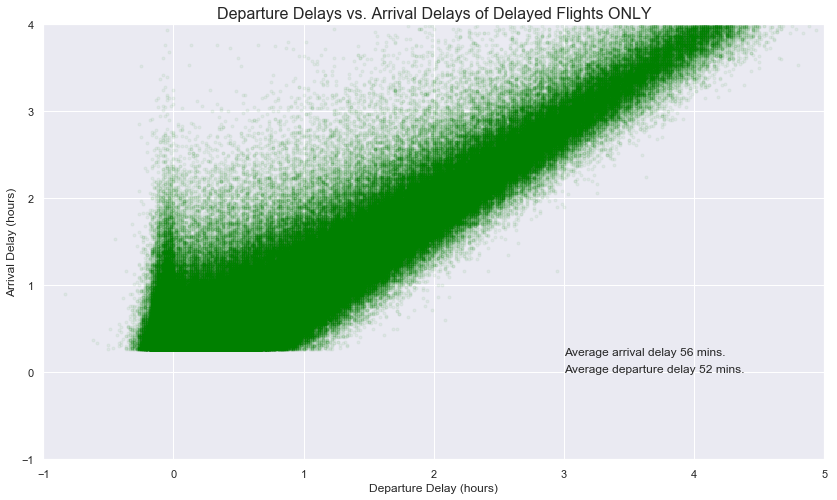

In [12]:
plt.plot(delays_15_4.DEP_DELAY / 60, delays_15_4.ARR_DELAY / 60, marker='.', linestyle='None', alpha = 0.05, color='green')
plt.xlim([-1, 5])
plt.ylim([-1, 4])
plt.xlabel('Departure Delay (hours)')
plt.ylabel('Arrival Delay (hours)')
plt.text(3, 0, f"Average departure delay {round((delays_15_4.DEP_DELAY).mean())} mins.")
plt.text(3, 0.2, f"Average arrival delay {round((delays_15_4.ARR_DELAY).mean())} mins.")
plt.title('Departure Delays vs. Arrival Delays of Delayed Flights ONLY', fontsize=16)
plt.show()

### There is a distinct linear relationship between departure delay and arrival delay, which makes sense. This means  we can also analyze departure delays and causes to predict arrival delays. We also see a small spike around the area of early departure or on time departure but late arrival. This is most likely due to airlines trying to get out on time even though they may be impacted by traffic at the airport, air traffic controll, or even weather. As such, arrival time may still be impacted

# A glimpse at the carrier performance throughout the year

In [13]:
#split the data into delayed flights (>15min. on arrival per FAA) and non-delayed flights
#we then sort the data by index in order to be able to get a ratio of delayed flights
flights_by_carrier = df.groupby('OP_CARRIER').size().sort_index()
flights_by_carrier_del = delays_15.groupby('OP_CARRIER').size().sort_index()
percent_delay = flights_by_carrier_del / flights_by_carrier

sorted_flights = flights_by_carrier.sort_values(ascending=False)
sorted_flights_del = flights_by_carrier_del.sort_values(ascending=False)

#When creating above dataframes we need to make sure that they all have the same index values so we can
#visualize the data correctly.
####use the same index for all data####
sorted_flights_del = sorted_flights_del.get(sorted_flights.index)
percent_delay = percent_delay.get(sorted_flights.index)

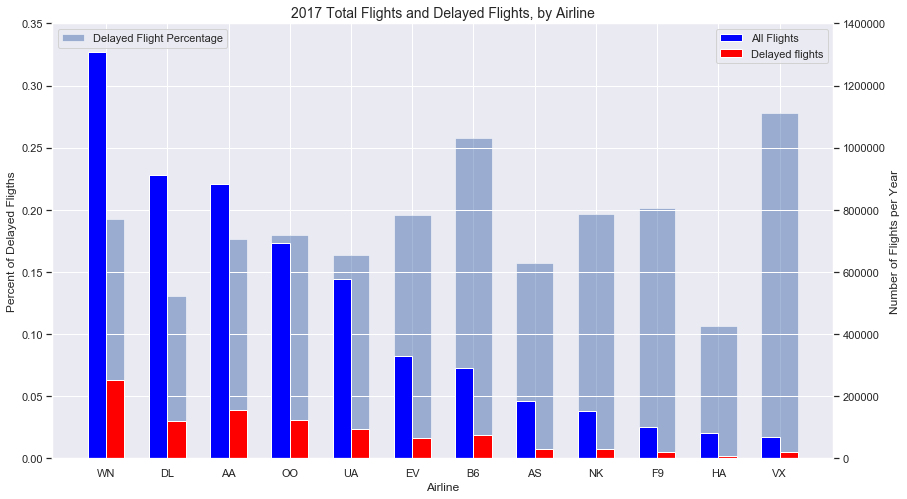

In [14]:
ax = plt.subplot(111)
ax.bar(sorted_flights.index, percent_delay, width=0.6, align='center', alpha=0.5)
plt.xlabel('Airline')
plt.ylabel('Percent of Delayed Fligths')
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylim(0,0.35)

ax2 = ax.twinx()
ax2.bar(sorted_flights.index, sorted_flights, width=-0.3, align='edge', color='blue')
ax2.bar(sorted_flights_del.index, sorted_flights_del, width=0.3, align='edge', color='red')
plt.legend(['All Flights', 'Delayed flights'])
plt.xlabel('Airline')
plt.ylabel('Number of Flights per Year')
plt.title(f'{year} Total Flights and Delayed Flights, by Airline', fontsize=14)
plt.ylim(0,1400000)
plt.show()

### Above chart shows the total number of flights, delayed flights, and the ratio of delayed flights broken down by airline. We can break this down by individual airline and look at top airport and top region performance

In [15]:
#Airline codes with names for cleaner presentation
airline_codes = pd.read_csv('L_CARRIER_HISTORY.csv')
airline_dict = airline_codes.set_index('Code').to_dict()['Description']

### Let's visualize arrival delay distribution by carrier. 
#### We'll need to cap the arrival delay to 60 minutes to be able to view the data due to the extreme outliers.

In [16]:
#create a dataframe from existing data containing only the columns we need
df_carriers = df[['OP_CARRIER', 'ORIGIN', 'DEST', 'ARR_DELAY']]

In [17]:
#add the airline names for easier interpretation 
df_carriers = pd.merge(df_carriers, airline_codes, how='left', left_on='OP_CARRIER', right_on='Code')

In [18]:
df_carriers['ARR_DELAY'] = df_carriers['ARR_DELAY'].apply(lambda x: 60 if x>=60 else x)
df_carriers['ARR_DELAY'] = df_carriers['ARR_DELAY'].apply(lambda x: -60 if x<=-60 else x)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


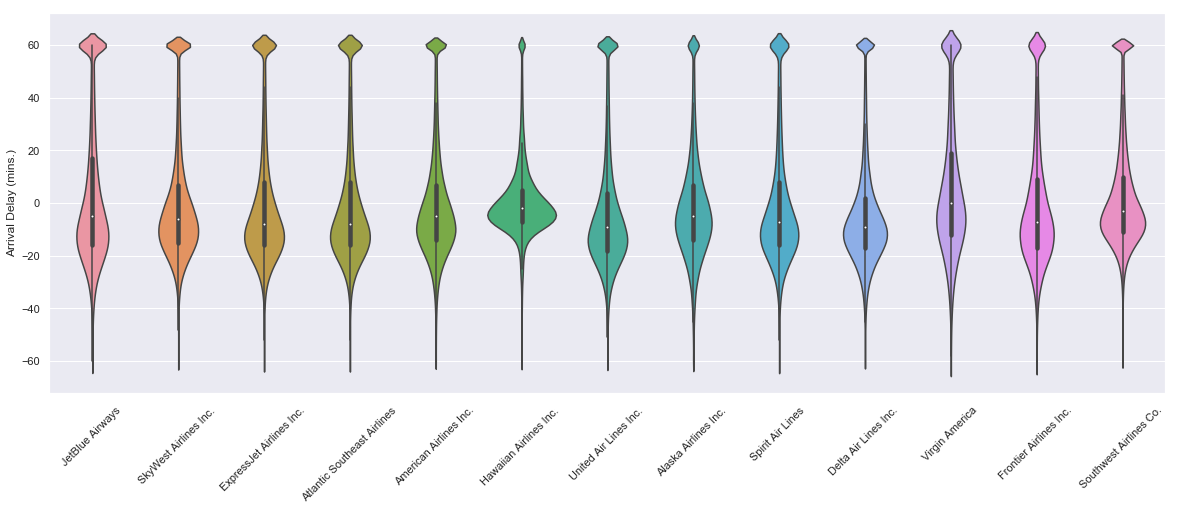

In [19]:
#visualize the data
plt.figure(figsize=(20,7))
ax = sns.violinplot(x='Description', y='ARR_DELAY', data=df_carriers)
ax.set_ylabel('Arrival Delay (mins.)')
ax.set_xlabel('')
label = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [167]:
percent_delay.index

CategoricalIndex(['WN', 'DL', 'AA', 'OO', 'UA', 'EV', 'B6', 'AS', 'NK', 'F9',
                  'HA', 'VX'],
                 categories=['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', ...], ordered=False, name='OP_CARRIER', dtype='category')

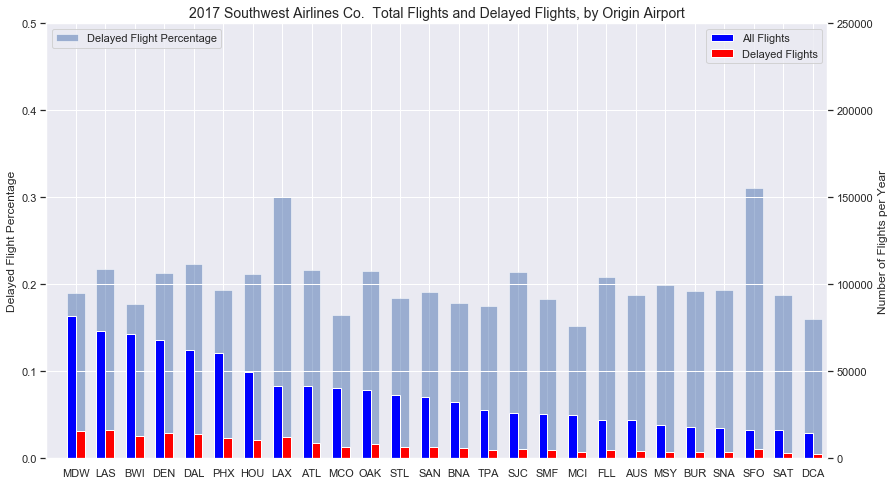

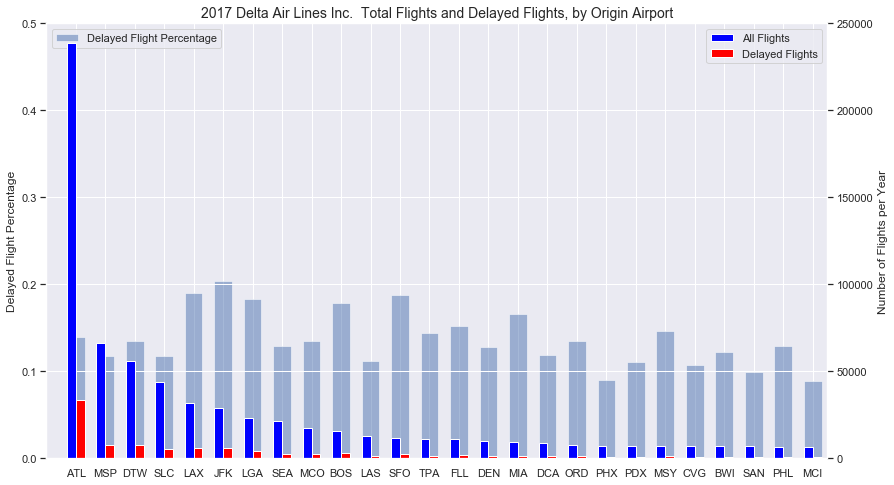

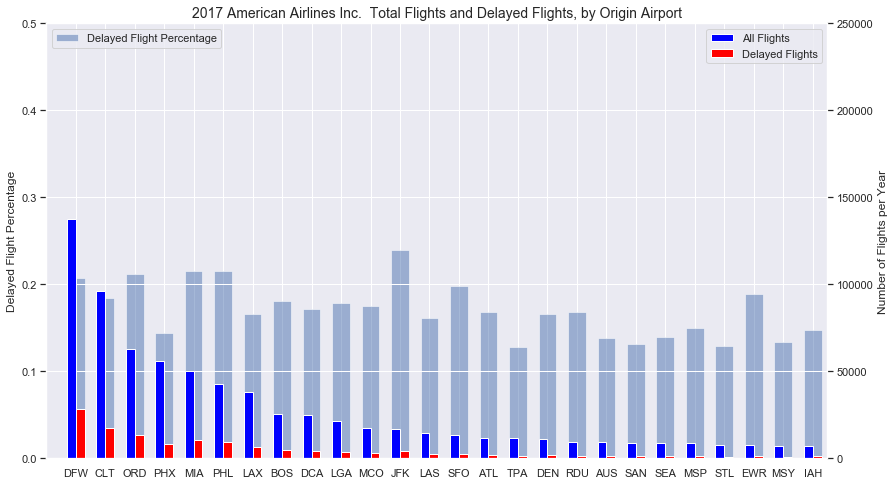

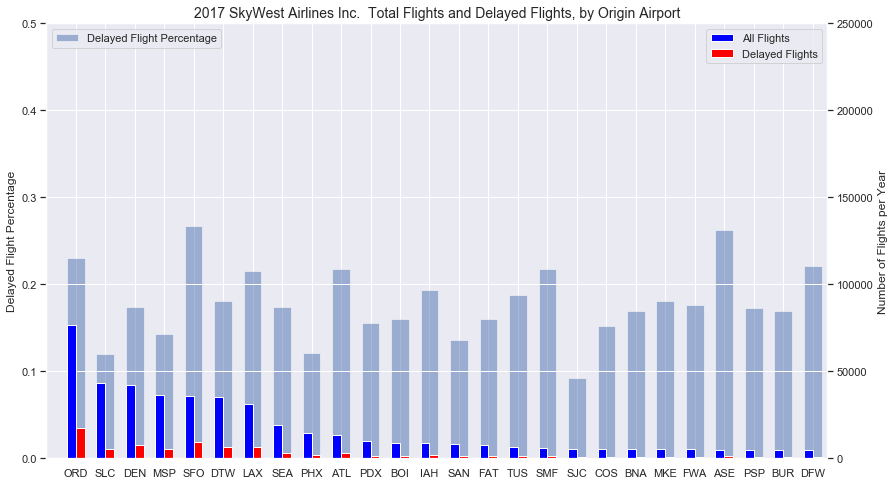

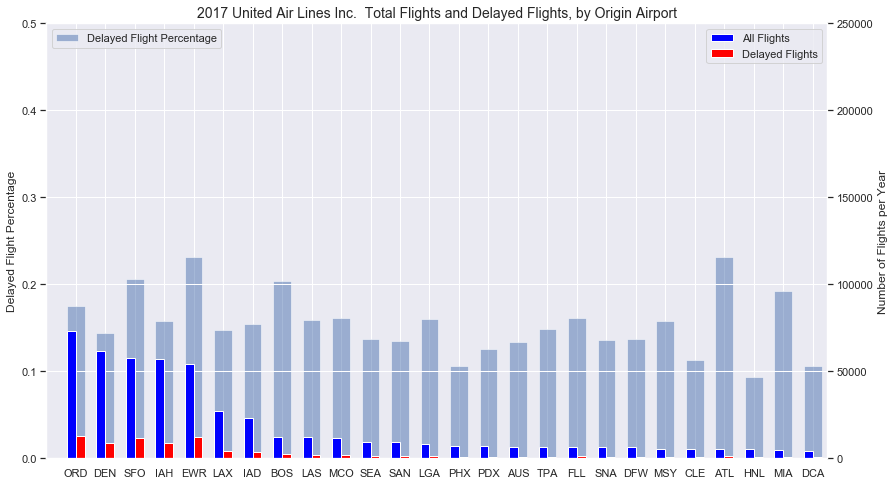

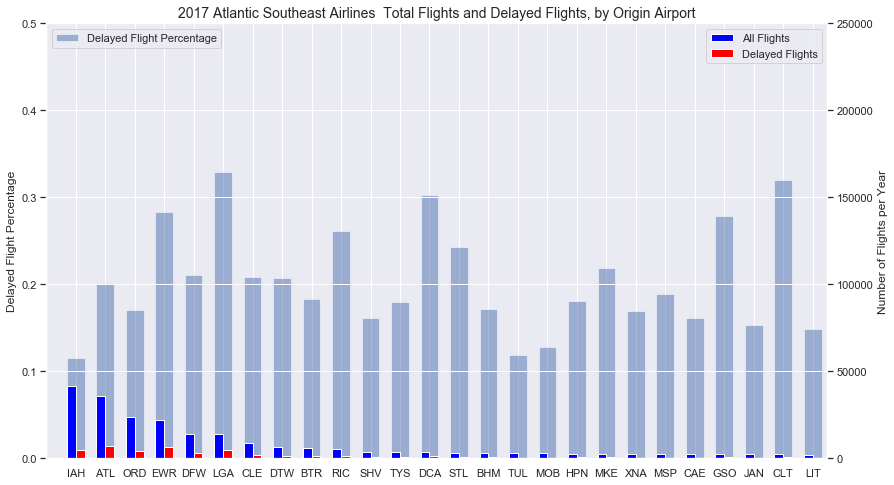

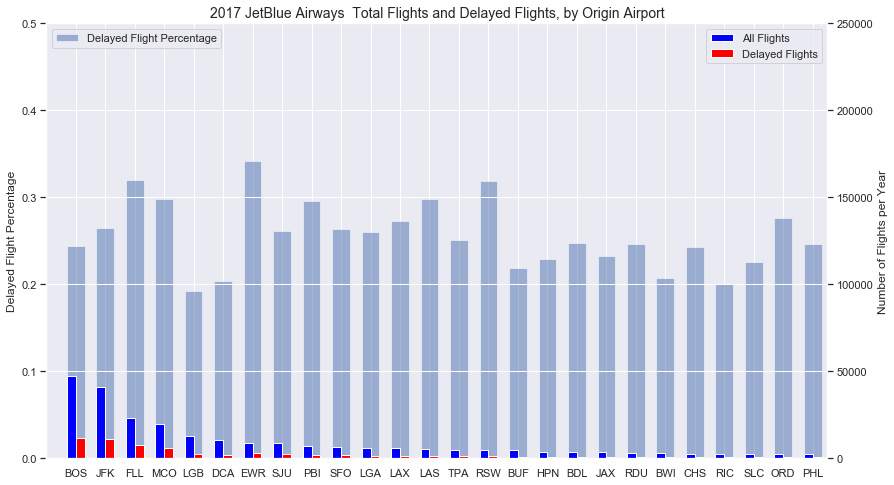

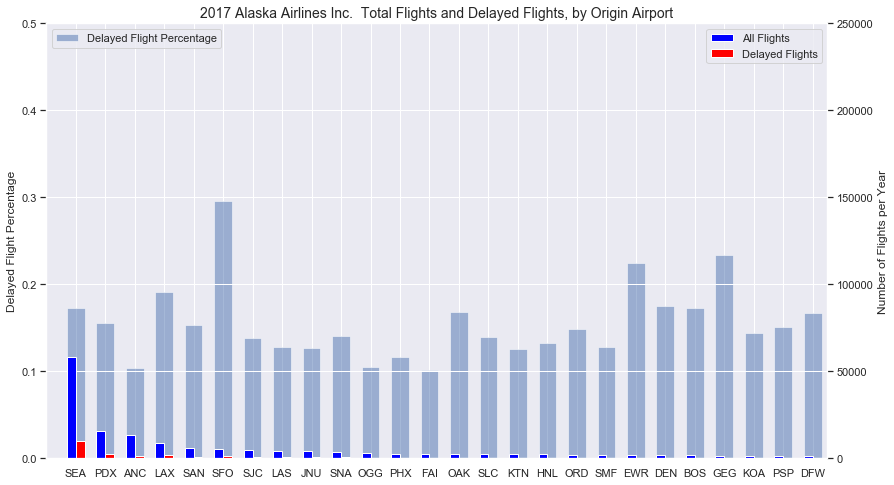

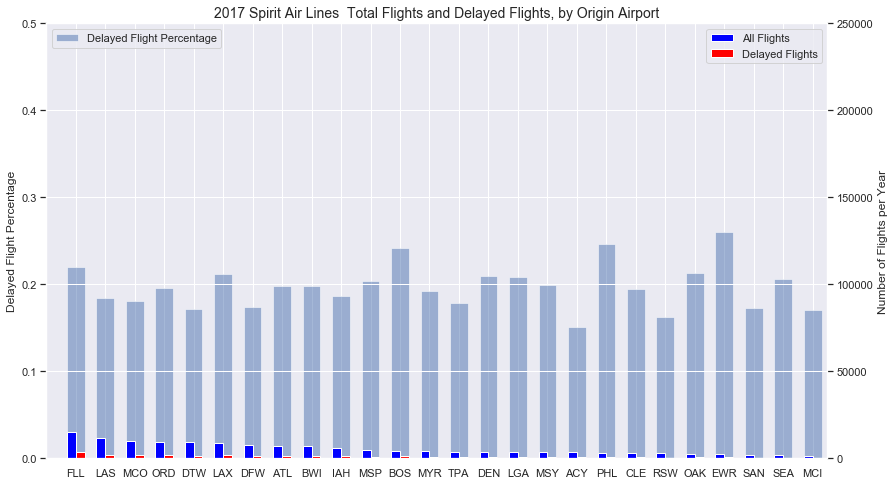

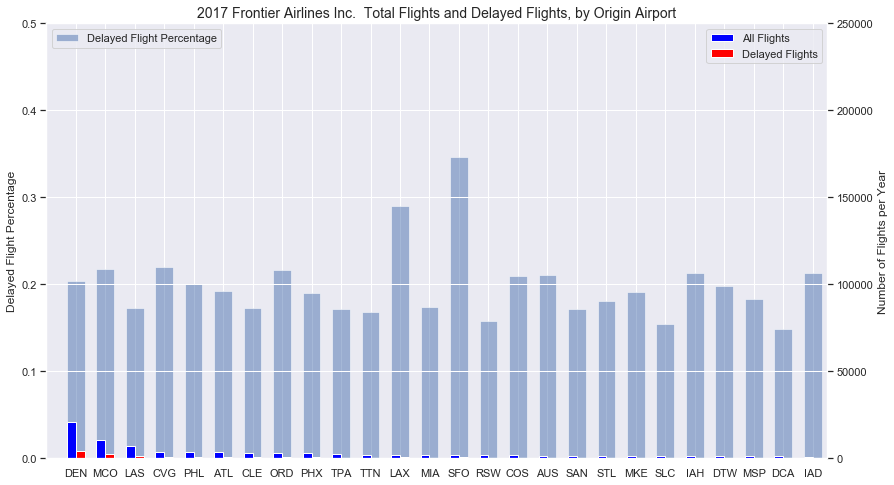

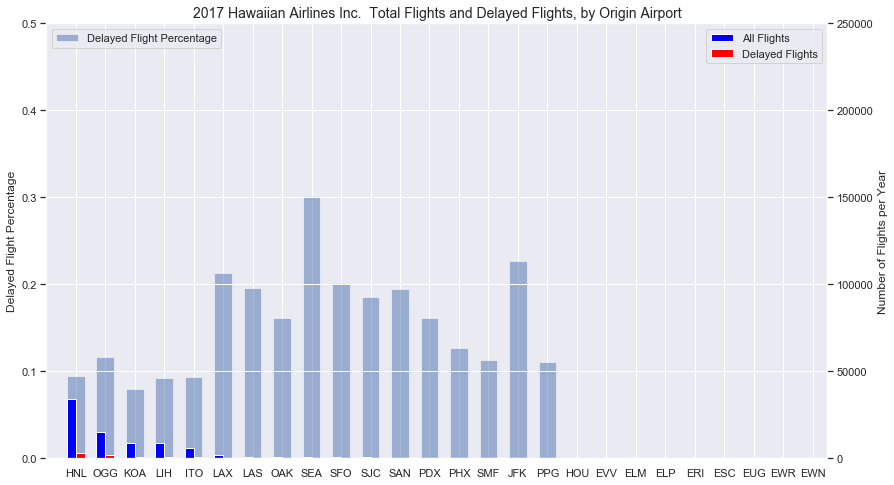

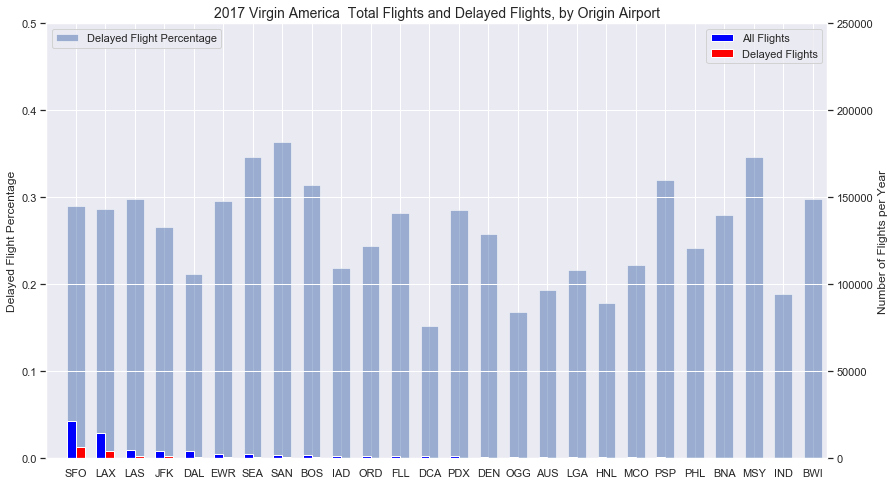

In [169]:
for name in percent_delay.index:
    airline_name=name
    #Let's break the above data down by airline.
    #Most flights are by Southwest and they have a relatively high delay frequency
    airline = df[df.OP_CARRIER == airline_name]
    airline_del = delays_15[delays_15.OP_CARRIER == airline_name]

    airline_byOrigin = airline.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]
    airline_byOrigin_del = airline_del.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]

    indexed_airline = airline.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
    indexed_airline_del = airline_del.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
    airline_ratio = indexed_airline_del / indexed_airline
    airline_ratio = airline_ratio.dropna(axis=0)
    delay_ratio = airline_ratio.get(airline_byOrigin.index)

    ####use the same index for all data
    airline_byOrigin_del = airline_byOrigin_del.get(airline_byOrigin.index)
    airline_disp_name = airline_dict.get(airline_name)
    
    ax = plt.subplot(111)
    ax.bar(airline_byOrigin.index, delay_ratio, width=0.6, align='center', alpha=0.5)
    plt.legend(['Delayed Flight Percentage'], loc='upper left')
    plt.ylabel('Delayed Flight Percentage')
    plt.ylim(0, 0.50)

    ax2 = ax.twinx()
    ax2.bar(airline_byOrigin.index, airline_byOrigin, width=-0.3, align='edge', color='blue')
    ax2.bar(airline_byOrigin_del.index, airline_byOrigin_del, width=0.3, align='edge', color='red')
    plt.legend(['All Flights', 'Delayed Flights'])
    plt.xlabel('Origin Airport')
    plt.ylabel('Number of Flights per Year')
    plt.title(f'{year} {airline_disp_name} Total Flights and Delayed Flights, by Origin Airport', fontsize=14)
    plt.xlim(-1,25.5)
    plt.ylim(0,250000)
    plt.show()

### Conclusion and summaries
#### Above analysis shows that the arrival delay percentage is highly variable and depends on airports and airlines, given all other factors are equal such as weather and traffic.

# Delays by airport

In [21]:
airports = df.groupby('ORIGIN').size().sort_values(ascending=False)[0:40]
airports_del = delays_15.groupby('ORIGIN').size().sort_values(ascending=False)[0:40]

test = df.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
test_del = delays_15.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()

ratio = test_del / test 
delay_ratio = ratio.get(airports.index)

####use the same index for all data
airports_del = airports_del.get(airports.index)

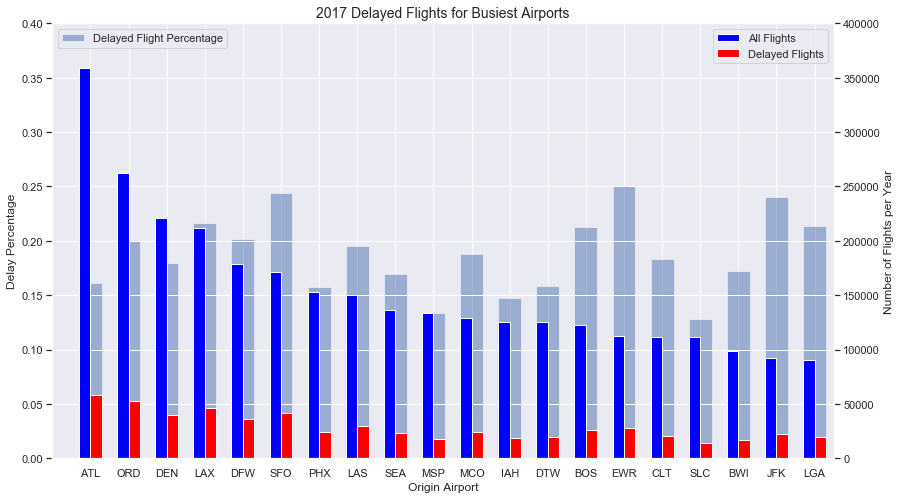

In [22]:
ax = plt.subplot(111)
ax.bar(delay_ratio.keys(), delay_ratio, width=0.6, align='center', alpha=0.5)
plt.ylim(0,0.4)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.xlabel('Origin Airport')
plt.ylabel('Delay Percentage')

ax2 = ax.twinx()
ax2.bar(airports.index, airports, width=-0.3, align='edge', color='blue')
ax2.bar(airports_del.index, airports_del, width=0.3, align='edge', color='red')
plt.legend([ 'All Flights', 'Delayed Flights'])

plt.ylabel('Number of Flights per Year')
plt.title(f'{year} Delayed Flights for Busiest Airports', fontsize=14)
plt.xlim(-1,19.5)
plt.ylim(0,400000)

plt.show()

# Regional Analysis 

In [23]:
#import airport location information csv
airport_location = pd.read_csv('airport_loc.csv')
#combine Latitude and Longitude into a tuple and form a new column and drop the Latitude & Longitude columns
airport_location['location'] = list(zip(airport_location.Latitude, airport_location.Longitude))
airports_locs = airport_location.copy()
airports_locs.head()
airports_locs.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
airport_loc = airports_locs.set_index('locationID').to_dict()['location']

In [24]:
#For regional calculation we'll set up a "radius" around the airport, for that we'll need a custom function
def radius(airport, miles):
    '''This function will return the absolute difference (in degrees) from the original location to the perimeter
    given the distance, and coordinates of the original location'''
    #based on ~69 miles per one degree of latitude
    coordinates = airport_loc.get(airport)
    #get the minimum and maximum latitudes, since latitude doesn't vary dramatically with distance away from equator
    #we can just compute the latitude variance by direct conversion of 69 miles per degree
    lat_var = miles / 69
    min_lat = coordinates[0] - lat_var
    max_lat = coordinates[0] + lat_var
    
    #longitude distance between degrees depends on the latitude, so we'll use the above computed latitudes to 
    #compute the variance in longitude
    long_min = miles / (math.cos(min_lat * math.pi / 180) * 69.172)  
    long_max = miles / (math.cos(max_lat * math.pi / 180) * 69.172)
    
    min_long = coordinates[1] - long_min
    max_long = coordinates[1] + long_max
    
    latitude = [min_lat, max_lat]
    longitude = [min_long, max_long]
    
    return latitude, longitude

In [25]:
def region_airports(airport, miles):
    '''This function takes airport code and distance around it as an input and
    returns a list of airport within the specified distance'''
    coordinates = radius(airport, miles)
    #print(coordinates)
    airports_locs = airport_location.copy()
    airports_locs = airports_locs[(airports_locs.Latitude >= coordinates[0][0]) & (airports_locs.Latitude <= coordinates[0][1]) &
                       (airports_locs.Longitude >= coordinates[1][0]) & (airports_locs.Longitude <= coordinates[1][1])]
    
    unique_list = airports_locs['locationID'].unique()
    return unique_list

## Input airport and radius in miles:

In [26]:
#returns a new dataframe with only the Origin airports that are within the specified radius
regional_airports = set(region_airports('SFO', 50))
all_airports = set(df.ORIGIN)
matching_local_airports = list(regional_airports.intersection(all_airports))
#"local" DataFrame only has origin airports
local = df[df.ORIGIN.isin(matching_local_airports)]

In [27]:
matching_local_airports.append('National Average')

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

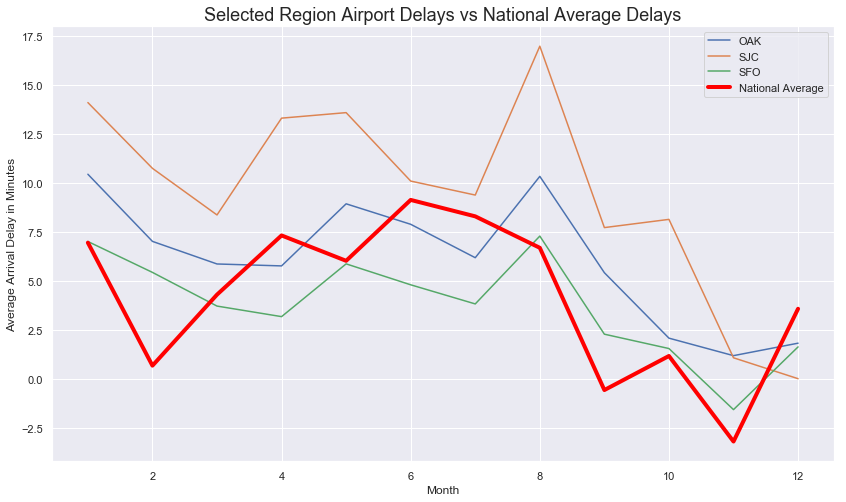

In [28]:
local.groupby(['MONTH', 'ORIGIN'])['ARR_DELAY'].mean().unstack().plot()
df.groupby(['MONTH'])['ARR_DELAY'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Month')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

In [29]:
local.groupby("ORIGIN")['ARR_DELAY'].mean().dropna()

ORIGIN
OAK    6.062908
SFO    9.414149
SJC    3.670820
Name: ARR_DELAY, dtype: float32

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

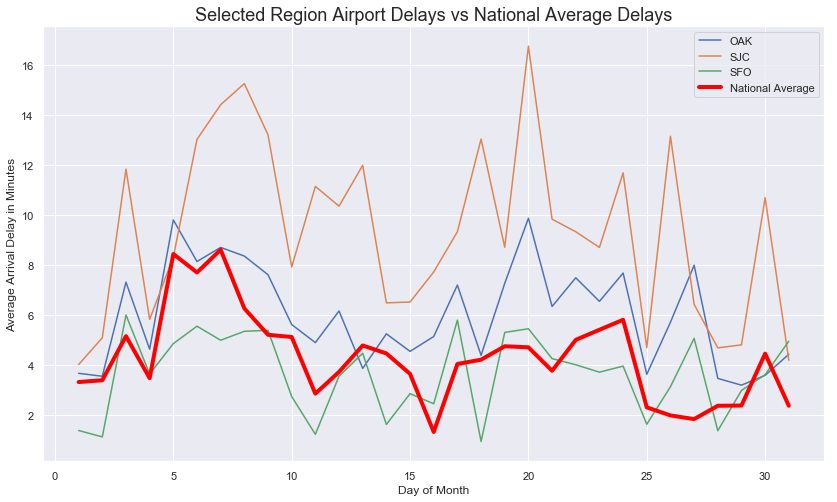

In [30]:
local.groupby(['DAY_OF_MONTH', 'ORIGIN'])['ARR_DELAY'].mean().unstack().plot()
df.groupby(['DAY_OF_MONTH'])['ARR_DELAY'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Day of Month')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

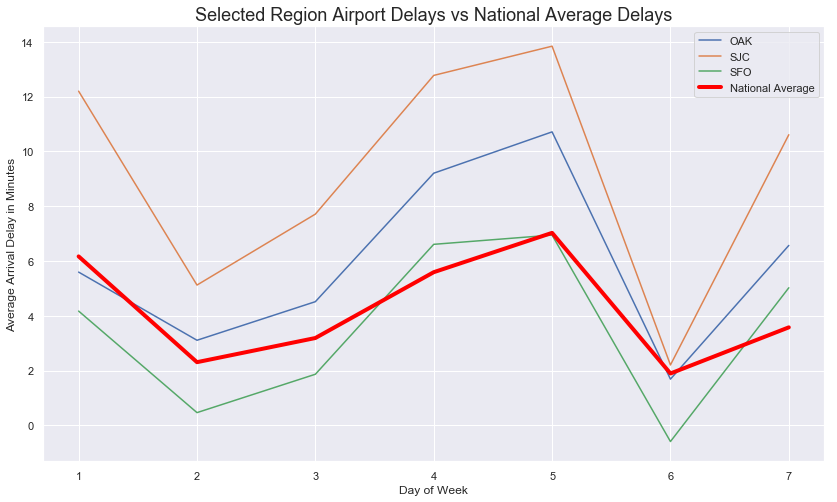

In [31]:
local.groupby(['DAY_OF_WEEK', 'ORIGIN'])['ARR_DELAY'].mean().unstack().plot()
df.groupby(['DAY_OF_WEEK'])['ARR_DELAY'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Day of Week')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

In [32]:
SFO = local[local.ORIGIN == 'SFO']
OAK = local[local.ORIGIN == 'OAK']
SJC = local[local.ORIGIN == 'SJC']

Text(0.5, 1.0, 'Arrival Delay Distribution')

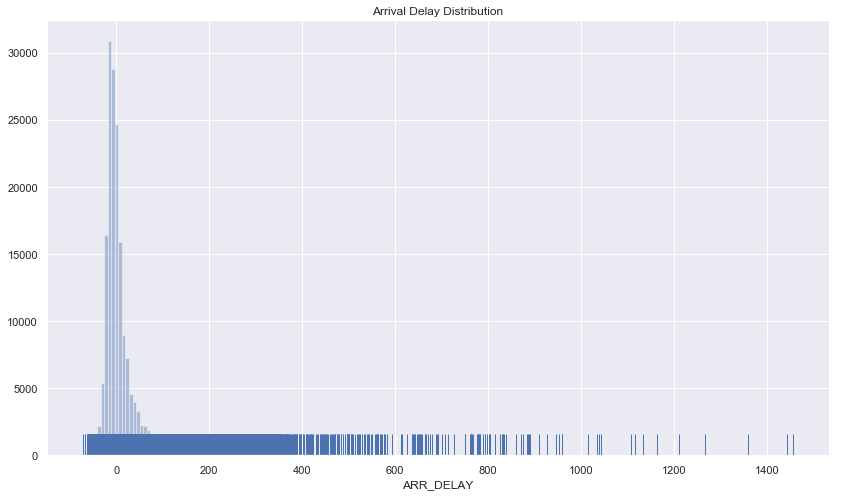

In [33]:
sns.distplot(SFO.ARR_DELAY, bins=200, kde=False, rug=True)
plt.title('Arrival Delay Distribution')

In [34]:
test2 = local.filter(items=['ORIGIN', 'ARR_DELAY'])

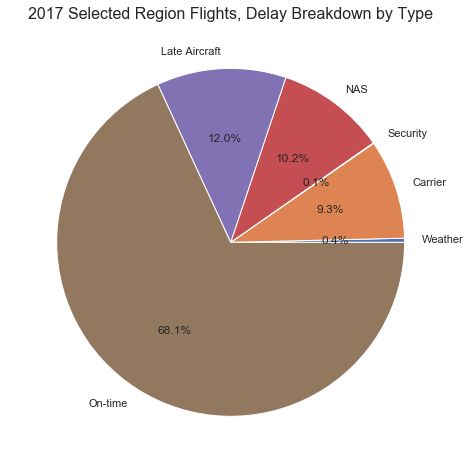

In [35]:
all_flights = local.YEAR.count()
on_time_df = local[local.ARR_DELAY <= 15]
delay_df = local[local.ARR_DELAY > 15]
on_time = on_time_df.YEAR.count()

weather = delay_df[delay_df.WEATHER_DELAY > 0].count()
carrier = delay_df[delay_df.CARRIER_DELAY > 0].count()
NAS = delay_df[delay_df.NAS_DELAY > 0].count()
security = delay_df[delay_df.SECURITY_DELAY > 0].count()
late_aircraft = delay_df[delay_df.LATE_AIRCRAFT_DELAY > 0].count()

weather_percent = weather.YEAR / all_flights
carrier_percent = carrier.YEAR / all_flights
NAS_percent = NAS.YEAR / all_flights
security_percent = security.YEAR / all_flights
late_aircraft_delay_percent = late_aircraft.YEAR / all_flights
no_delay_percent = on_time / all_flights

x = [weather_percent, carrier_percent, security_percent, NAS_percent, late_aircraft_delay_percent, no_delay_percent]

plt.pie(x, labels=['Weather', 'Carrier', 'Security', 'NAS', 'Late Aircraft', 'On-time'], autopct='%1.1f%%')
plt.title(f'{year} Selected Region Flights, Delay Breakdown by Type', fontsize=16)
plt.show()

In [36]:
del matching_local_airports[-1]

### FAA has data available for NAS delays, further broken down by category.
https://aspm.faa.gov/opsnet/sys/Delays.asp

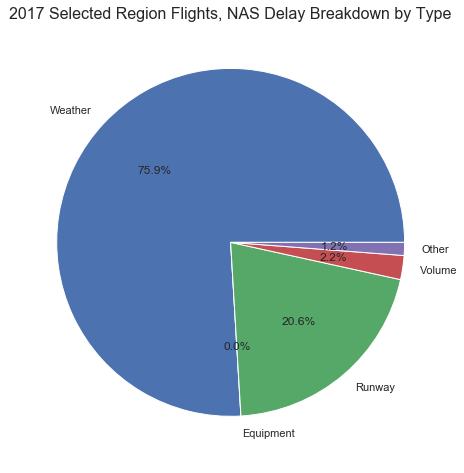

In [37]:
nas_delay = pd.read_csv('NAS_delay.csv')
NAS_by_year = nas_delay[(nas_delay.Year == float(year)) & nas_delay.Facility.isin(matching_local_airports)]
total_time = NAS_by_year.groupby('Facility')['all Total min.'].sum().sort_index()
volume_time = NAS_by_year.groupby('Facility')['volume total'].sum().sort_index()
equipment_time = NAS_by_year.groupby('Facility')['Equipment total'].sum().sort_index()
runway_time = NAS_by_year.groupby('Facility')['runway total'].sum().sort_index()
other_time = NAS_by_year.groupby('Facility')['other total'].sum().sort_index()
weather_time = NAS_by_year.groupby('Facility')['Weather total'].sum().sort_index()

percent_volume = volume_time / total_time
percent_equipment = equipment_time / total_time
percent_runway = runway_time / total_time
percent_other = other_time / total_time
percent_weather = weather_time / total_time

total_time = total_time.sort_values(ascending=False)

percent_volume = percent_volume.get(total_time.index)[0:100]
percent_equipment = percent_equipment.get(total_time.index)[0:100]
percent_runway = percent_runway.get(total_time.index)[0:100]
percent_other = percent_other.get(total_time.index)[0:100]
percent_weather = percent_weather.get(total_time.index)[0:100]

all_weather = weather_time.sum() / total_time.sum()
all_equipment = equipment_time.sum() / total_time.sum()
all_runway = runway_time.sum() / total_time.sum()
all_volume = volume_time.sum() / total_time.sum()
all_other = other_time.sum() / total_time.sum()

x = [all_weather, all_equipment, all_runway, all_volume, all_other]

plt.pie(x, labels=['Weather', 'Equipment', 'Runway', 'Volume', 'Other'], autopct='%1.1f%%')
plt.title(f'{year} Selected Region Flights, NAS Delay Breakdown by Type', fontsize=16)
plt.show()

Weather delay average: 0.9781098365783691 mins.
Carrier delay average: 15.160774230957031 mins.
NAS delay average: 11.945009231567383 mins.
Security delay average: 0.07797471433877945 mins.
Late Aircraft delay average: 29.91107177734375 mins.


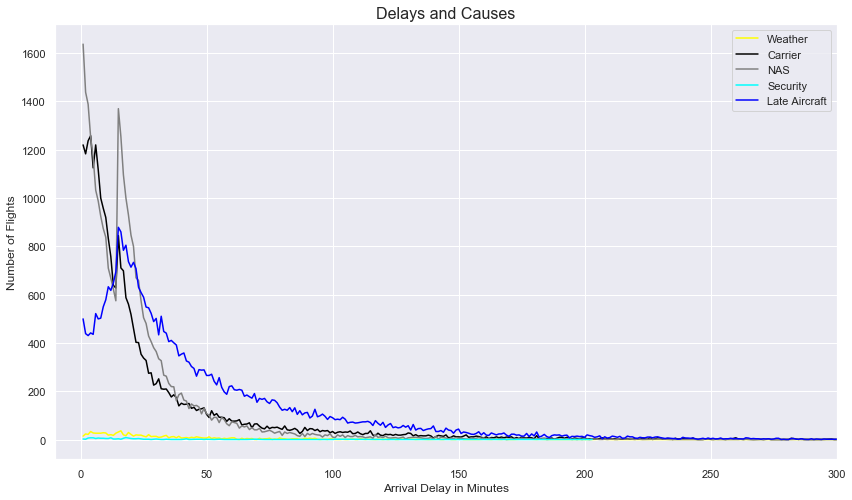

In [38]:
print(f'Weather delay average: {local.WEATHER_DELAY.mean()} mins.')
print(f'Carrier delay average: {local.CARRIER_DELAY.mean()} mins.')
print(f'NAS delay average: {local.NAS_DELAY.mean()} mins.')
print(f'Security delay average: {local.SECURITY_DELAY.mean()} mins.')
print(f'Late Aircraft delay average: {local.LATE_AIRCRAFT_DELAY.mean()} mins.')

local.groupby('WEATHER_DELAY').size()[1:].plot(color='yellow')
local.groupby('CARRIER_DELAY').size()[1:].plot(color='black')
local.groupby('NAS_DELAY').size()[1:].plot(color='gray')
local.groupby('SECURITY_DELAY').size()[1:].plot(color='cyan')
local.groupby('LATE_AIRCRAFT_DELAY').size()[1:].plot(color='blue')
plt.xlim(-10,300)
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Number of Flights')
plt.title('Delays and Causes', fontsize=16)
plt.legend(['Weather', 'Carrier', 'NAS', 'Security', 'Late Aircraft'])

### NAS - We can continue to look at patterns for heavy traffic or trends in increassing air traffic patterns areas and look for consitancies. Addionally, although extreme events are not considered here, normal weather patterns that cause air traffic slowdowns are. Looking at weather patterns may be beneficial. FAA has a database breaking down the NAS delays by cause. (FAA OPSNET)

### Carrier - carrier performance can be further analyzed by location and see if there are patterns

### Late Aircraft - This can be handled with arrival delay information. This field highly depends on the other delay causes.

# Evaluating congested times in a selected region

## Do busy times in a given region have a higher arrival delay time?

In [39]:
#define a useful function
def time_to_float(time):
    '''This function will convert time that is incorrectly represented into a float
    for easier plotting with matplotlib'''
    if len(str(int(time))) > 2:
        denom = time / 2400.0
        numer = (float(str(int(time))[:-2:]) + float(str(int(time))[-2:])/60)/24
        ratio = numer / denom
        time_float = time * ratio
    else:
        time_float = time / 60 * 100 
    return time_float

In [40]:
matching_local_airports

['OAK', 'SJC', 'SFO']

In [115]:
#we'll need to consider all arriving and departing traffic in the region to undestand congestion delays
arriving_flights = df[df.DEST.isin(matching_local_airports)]
departing_flights = df[df.ORIGIN.isin(matching_local_airports)]

In [116]:
#add columns converting departure and arrival time to hourly increments
arriving_flights['ARR_HOUR'] = arriving_flights['ARR_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
arriving_flights['ARR_HOUR'] = arriving_flights['ARR_HOUR'].apply(lambda x:0 if x==24 else x)
departing_flights['DEP_HOUR'] = departing_flights['CRS_DEP_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [133]:
arr_del = pd.DataFrame(arriving_flights.groupby('ARR_HOUR')['ARR_DELAY'].mean())
dep_del = pd.DataFrame(departing_flights.groupby('DEP_HOUR')['ARR_DELAY'].mean())

In [137]:
total_del = pd.merge(arr_del, dep_del, how='left', left_on=arr_del.index, right_on=dep_del.index)

In [139]:
total_del['sum'] = total_del['ARR_DELAY_x'] + total_del['ARR_DELAY_y']

In [141]:
total_del.drop(columns=['key_0'])

,ARR_DELAY_x,ARR_DELAY_y,sum
0,57.173401,-1.625105,55.548298
1,90.925606,10.110092,101.035698
2,164.768661,NaN,NaN
3,179.373337,199.000000,378.373352
4,0.142327,NaN,NaN
5,-0.516883,-5.551373,-6.068255
6,-13.556052,-0.752640,-14.308692
7,-8.472144,-2.693028,-11.165173
8,-4.274644,1.473073,-2.801571
9,-4.496089,4.243458,-0.252631


In [142]:
total_del.fillna(0)

,key_0,ARR_DELAY_x,ARR_DELAY_y,sum
0,0,57.173401,-1.625105,55.548298
1,1,90.925606,10.110092,101.035698
2,2,164.768661,0.000000,0.000000
3,3,179.373337,199.000000,378.373352
4,4,0.142327,0.000000,0.000000
5,5,-0.516883,-5.551373,-6.068255
6,6,-13.556052,-0.752640,-14.308692
7,7,-8.472144,-2.693028,-11.165173
8,8,-4.274644,1.473073,-2.801571
9,9,-4.496089,4.243458,-0.252631


In [117]:
arr = pd.DataFrame(arriving_flights.groupby('ARR_HOUR').size())
dep = pd.DataFrame(departing_flights.groupby('DEP_HOUR').size())

In [123]:
total = pd.merge(arr, dep, how='left', left_on=arr.index, right_on=dep.index)

In [126]:
total['sum'] = total['0_x'] + total['0_y']

In [129]:
total.drop(columns=['key_0'])

,0_x,0_y,sum
0,5346,2390.0,7736.0
1,1976,109.0,2085.0
2,536,NaN,NaN
3,150,1.0,151.0
4,808,NaN,NaN
5,770,2550.0,3320.0
6,3577,21495.0,25072.0
7,11416,15060.0,26476.0
8,15085,21020.0,36105.0
9,17003,19527.0,36530.0


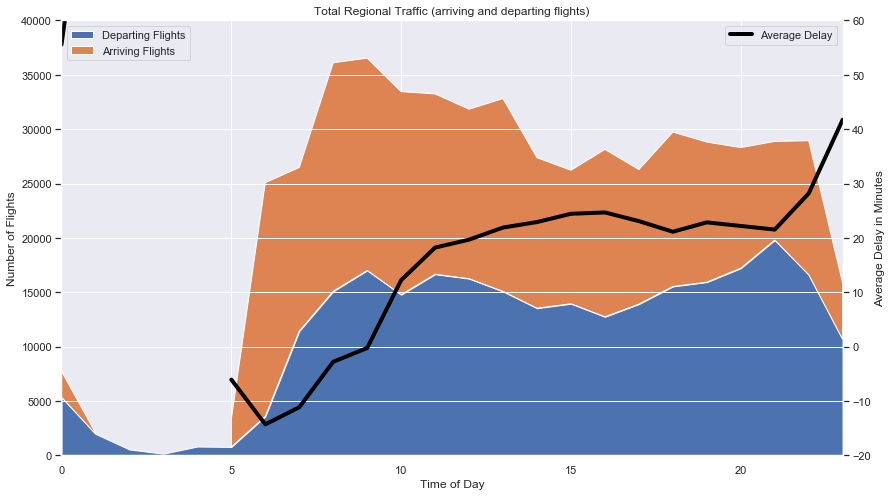

In [166]:
ax = plt.subplot(111)
y = [total['0_x'], total['0_y']]
x = total.index

ax.stackplot(x, y, labels=['Departing Flights','Arriving Flights'])
plt.legend(loc='upper left')
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights')
plt.title('Total Regional Traffic (arriving and departing flights)')
plt.ylim(0,40000)
plt.xlim(0,23)

ax2 = ax.twinx()
ax2.plot(total_del.index, total_del['sum'], color='black', linewidth=4)
plt.ylabel('Average Delay in Minutes')
plt.ylim(-20,60)
plt.legend(['Average Delay'], loc='upper right')

plt.show()

It looks like delays increase towards the evening hours of the day.

### How do airlines perform throughout the week by hour. Is there a time of the week that results in more delays?

In [47]:
#add columns converting departure and arrival time to hourly increments
local['DEP_HOUR'] = local['CRS_DEP_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
local['ARR_HOUR'] = local['ARR_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
local_sub = local[['DAY_OF_WEEK','DEP_HOUR','OP_CARRIER','ARR_DELAY']]

In [49]:
local_sub['DAY_OF_WEEK'].replace(1,'Monday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(2,'Tuesday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(3,'Wednesday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(4,'Thursday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(5,'Friday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(6,'Saturday',inplace=True)
local_sub['DAY_OF_WEEK'].replace(7,'Sunday',inplace=True)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [50]:
local_sub.head()

,DAY_OF_WEEK,DEP_HOUR,OP_CARRIER,ARR_DELAY
12,Tuesday,20,B6,-43.0
48,Tuesday,14,B6,-30.0
69,Tuesday,11,B6,58.0
90,Tuesday,13,B6,-45.0
120,Tuesday,23,B6,-45.0


In [51]:
monday = local_sub[local_sub.DAY_OF_WEEK == 'Monday']
monday = monday.reset_index()
monday = monday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
monday = monday.groupby('DEP_HOUR').mean()

tuesday = local_sub[local_sub.DAY_OF_WEEK == 'Tuesday']
tuesday = tuesday.reset_index()
tuesday = tuesday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
tuesday = tuesday.groupby('DEP_HOUR').mean()

wednesday = local_sub[local_sub.DAY_OF_WEEK == 'Wednesday']
wednesday = wednesday.reset_index()
wednesday = wednesday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
wednesday = wednesday.groupby('DEP_HOUR').mean()

thursday = local_sub[local_sub.DAY_OF_WEEK == 'Thursday']
thursday = thursday.reset_index()
thursday = thursday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
thursday = thursday.groupby('DEP_HOUR').mean()

friday = local_sub[local_sub.DAY_OF_WEEK == 'Friday']
friday = friday.reset_index()
friday = friday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
friday = friday.groupby('DEP_HOUR').mean()

saturday = local_sub[local_sub.DAY_OF_WEEK == 'Saturday']
saturday = saturday.reset_index()
saturday = saturday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
saturday = saturday.groupby('DEP_HOUR').mean()

sunday = local_sub[local_sub.DAY_OF_WEEK == 'Sunday']
sunday = sunday.reset_index()
sunday = sunday.drop(['index', 'OP_CARRIER', 'DAY_OF_WEEK'], axis=1)
sunday = sunday.groupby('DEP_HOUR').mean()

In [52]:
thursday = thursday.drop([3])

In [53]:
thursday.iloc[2]

ARR_DELAY   -6.294393
Name: 5, dtype: float32

In [54]:
new_df = pd.DataFrame()

In [55]:
new_df['Monday'] = monday.ARR_DELAY.values
new_df['Tuesday'] = tuesday.ARR_DELAY.values
new_df['Wednesday'] = wednesday.ARR_DELAY.values
new_df['Thursday'] = thursday.ARR_DELAY.values
new_df['Friday'] = friday.ARR_DELAY.values
new_df['Saturday'] = saturday.ARR_DELAY.values
new_df['Sunday'] = sunday.ARR_DELAY.values

In [56]:
new_df = new_df.reset_index()

In [59]:
line = pd.DataFrame({"index": 0.0, "Monday": 0.0, "Tuesday": 0.0, "Wednesday": 0.0, "Thursday": 0.0,
                 "Friday": 0.0, "Saturday": 0.0, "Sunday": 0.0,}, index=[1.5])
new_df = new_df.append(line, ignore_index=False)
new_df = new_df.sort_index().reset_index(drop=True)

In [60]:
new_df = new_df.drop(columns=['index'])

In [61]:
hour_day = new_df.copy()

In [62]:
hour_day.index = hour_day.index.astype(str)

In [63]:
from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.transform import transform

In [65]:
hour_day.columns.name = 'Day'

test = pd.DataFrame(hour_day.stack(), columns=['ARR_DELAY']).reset_index()
source = ColumnDataSource(test)

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=test.ARR_DELAY.min(), high=test.ARR_DELAY.max())
heatmap = figure(plot_width=900, plot_height=300, title='Average Flight Delays by Day and Hour for All Airlines',
                 x_range=list(hour_day.index), y_range=list(hour_day.columns))
heatmap.rect(x='level_0', y="Day", width=1, height=1, source=source,
       line_color=None, fill_color=transform('ARR_DELAY', mapper))


color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)))

heatmap.add_layout(color_bar, 'right')

heatmap.xaxis.axis_label = 'Departure Hour'
heatmap.yaxis.axis_label = 'Day of the Week'

heatmap.axis.axis_line_color = None
heatmap.axis.major_tick_line_color = None
heatmap.axis.major_label_text_font_size = "8pt"
heatmap.axis.major_label_standoff = 0
heatmap.xaxis.major_label_orientation = 1.0

show(heatmap)

<img src="bokeh_plot-2.png">

We see that Thursday, Friday, and Sunday afternoons seem particularly busy for this region.

In [172]:
df.DEP_TIME.head()

0    1031.0
1    1420.0
2    1203.0
3     758.0
4    1041.0
Name: DEP_TIME, dtype: float32